In [2]:
#to avoid trouble with accelerate later on!
#pip uninstall transformer_engine -y

In [3]:
!nvidia-smi

Wed Nov 29 15:10:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   45C    P0              57W / 400W |     22MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Set up lmql model

In [4]:
import lmql

model = lmql.model(
    "local:HuggingFaceH4/zephyr-7b-alpha",
    device_map = "auto",
    load_in_8bit=True,
    low_cpu_mem_usage=True
)


## LMQL Queries

In [5]:
@lmql.query
async def init(stance, topic, n=1):
    '''lmql
    sample(temperature=0.9)
      "<|user|>\n"
      "# Provide a claim that corresponds to a given stance\n\n"
      "Alice is going to debate '{topic}'.\n"
      "For the purpose of the debate, she'll initially adopt a claim that is {stance} {topic}.\n\n"
      "Can you please suggest {n} such claims?\n\n"
      "State each claim in a single sentence, keeping it short an concise. "
      "Make sure you provide sufficiently diverse claims.\n"
      "<|assistant|>\n"
      "Alice might defend one of the following claims:\n"
      claims = []
      for _ in range(n):
        "  * \"[OPINION]\"\n" where STOPS_AT(OPINION, ".") and STOPS_AT(OPINION, "!") and STOPS_AT(OPINION, '"') and len(OPINION)<220
        claims.append(OPINION)
      return claims
    '''


@lmql.query
async def revise(opinion, peer_opinions, self_confidence, topic):
    '''lmql
    sample(temperature=0.6)
      "<|user|>\n"
      "# Recommend whether and how to revise an opinion"
      "Alice has been debating '{topic}'.\n"
      "She has previously held the following opinion.\n\n"
      "Alice: \"{opinion}\"\n\n"
      "Now, through debating '{topic}', she has learned that her peers maintain the following views:\n"
      for peer_opinion in peer_opinions:
        "- {peer_opinion}\n"
      "\n"
      "Alice considers her peers trustworthy and reliable.\n"
      "Alice has {self_confidence} confidence in her previously held opinion and accordingly {self_confidence} resistance to changing her opinion.\n\n"
      "This being said, which opinion will Alice adopt in the future, having heard about her peers' views?\n"
      "1. Repeat Alice's previously held opinion.\n"
      "2. State Alice's future opinion in a single sentence, keeping it short an concise.\n"
      "<|assistant|>\n"
      "1. Alice's previous opinion: \"{opinion}\"\n"
      "2. Alice's future opinion: \"[REVISION]" where STOPS_AT(REVISION, ".") and STOPS_AT(REVISION, "!") and STOPS_AT(REVISION, '"') and len(REVISION)<240
      return REVISION.strip('"')
    '''

#       "What's a compromise position that balances Alice's opinion and those of her peers? State the compromise in a single sentence, keeping it "


@lmql.query
async def agreement(own, other):
    '''lmql
    argmax
      "<|user|>\n"
      "# Assess perceived expertise\n\n"
      "Suppose Alice and Bob are debating 'veganism'.\n"
      "They hold the following opinions.\n\n"
      "Alice: {own}\n\n"
      "Bob: {other}\n\n"
      "Given these opinions, is Alice prepared to listen to what Bob has to say and take his view into account when revising her beliefs?\n"
      "To address this question, let's assess how similar Bob's and Alice's opinions are:"
      "(A) very similiar\n"
      "(B) somewhat similar\n"
      "(C) neither similar nor opposing\n"
      "(D) somewhat opposing\n"
      "(E) strongly opposing\n"
      "Just answer with A/B/C/D/E (you'll be asked to explain your answer later on)."
      "<|assistant|>\n"
      "[LABEL]"
    distribution
      LABEL in ["A","B","C","D","E"]
    '''

In [126]:
lmql_result = await agreement(
    "It's outright irresponsible to eat meat.",
    "I think it's ok to eat a nice cheese cake from time to time.",
    model=model
)
probs = lmql_result.variables.get("P(LABEL)")
sum([i*v for i, (_, v) in enumerate(probs)])/4.0

0.45141129254875595

In [127]:
async def numagree(own, other):
    lmql_result = await agreement(
        own,
        other,
        model=model
    )
    probs = lmql_result.variables.get("P(LABEL)")
    return sum([i*v for i, (_, v) in enumerate(probs)])/4.0

await numagree(
    "It's outright irresponsible to eat meat.",
    "I think it's ok to eat a nice cheese cake from time to time.",
)

0.468981586849801

In [131]:
result = await revise(
    opinion="It's outright irresponsible to eat meat.",
    peer_opinions=[
        "I think it's ok to eat a nice burger every day.",
        "I think it's ok to eat a nice cheese cake from time to time.",
    ],
    topic="veganism",
    self_confidence="low",
    model=model
)
print(result)

I still believe that eating meat regularly is irresponsible, but occasionally indulging in a burger or cheese cake is acceptable.


In [ ]:
await revise(
    opinion="It's outright irresponsible to eat meat.",
    peer_opinions=[
        "I never eat meat, not even dietary products.",
        "I think it's ok to eat a nice cheese cake from time to time.",
        "It's outright irresponsible to eat meat.",
        "It's outright irresponsible to eat meat.",
    ],
    topic="veganism",
    self_confidence="extremely high",
    model=model
)

In [28]:
await init(
    topic="veganism",
    stance="vaguely putting in doubt",
    n=5,
    model=model
)

['Studies have shown that vegans may have a higher risk of certain nutrient deficiencies than those who consume animal products.',
 'A balanced, omnivorous diet is best for human health because it provides a complete set of nutrients that cannot always be obtained through vegan options.',
 'The environmental impact of raising animals for food is not as severe as once thought, and some experts suggest that consuming a moderate amount of meat can be acceptable for environmental reasons.',
 'There is evidence from multiple medical studies that a diet containing animal products can actually protect against certain chronic diseases, including heart disease and type 2 diabetes.',
 'The consumption of animal products has been a part of the human diet for thousands of years and has likely contributed to our advanced cognitive development, unlike the diets of purely plant-based animals.']

In [18]:
await init(
    topic="veganism",
    stance="based on (positive) personal experience regarding",
    n=3,
    model=model
)

['I noticed significant improvements in my overall health, including a decrease in weight, cholesterol, and inflammation, after adopting a vegan diet.',
 'As a long-time vegan, I have never experienced a nutrient deficiency and have been able to maintain a balanced diet without consuming animal products.',
 'I can confidently say that since switching to a vegan lifestyle, I have reduced pollution, greenhouse gas emissions, and water consumption while also supporting environmentally sustainable farming practices.']

## Skeleton BC Model

In [6]:
import copy
import numpy as np
import random
import uuid

In [7]:
class AbstractBCAgent():

    def __init__(self, initial_opinion, **kwargs):
        self.opinion = initial_opinion
        self._step = 0
        self._distances = {}
        self._parameters = kwargs
        self.uid = str(uuid.uuid4())

    async def update(self, community):
        """updates agent state"""
        peers = await self.peers(community)
        opinions = [peer.opinion for peer in peers]
        if opinions:
            self.opinion = await self.revise(opinions)
        self._step += 1

    async def peers(self, community):
        """returns agents with opinion distance smaller than epsilon"""
        epsilon = self._parameters.get("epsilon", .1)
        self._distances = {
            agent.uid: await self.distance(agent.opinion)
            for agent in community if agent.uid != self.uid
        }
        print(self._distances)
        peers = [
            agent for agent in community
            if self._distances.get(agent.uid,1) <= epsilon and
            agent.uid != self.uid
        ]
        return peers

    def distance(self, opinion):
        """calculates distance between agent's and other opinion"""

    def revise(self, opinions):
        """revises agent's opinion given opinions (of peers)"""

    def log_state(self):
        """agent state for logging"""
        return {"uid": self.uid, "opinion": self.opinion, "distances": self._distances}


In [8]:
from tqdm import tqdm

class EpistemicCommunity():

    def __init__(self, agents: list[AbstractBCAgent]):
        self.agents = agents
        self.logs = []
        self.log(0)

    async def interact(self, max_steps=10):
        for step in tqdm(range(max_steps), "STEP"):
            agents_snapshot = copy.deepcopy(self.agents)
            for agent in self.agents:
                await agent.update(agents_snapshot)
            self.log(step+1)

    def log(self, step):
        self.logs.append({
            "step": step,
            "agents": [agent.log_state() for agent in self.agents]
        })

## Numerical BC Model

In [9]:
class NumericalBCAgent(AbstractBCAgent):

    async def distance(self, opinion):
        """calculates distance between agent's and other opinion"""
        return abs(opinion - self.opinion)

    async def revise(self, opinions):
        """revision through weighted opinion averaging"""
        alpha = self._parameters.get("alpha", .5)
        revision = alpha * self.opinion + (1-alpha) * np.mean(opinions)
        return revision

In [10]:
N = 23
community = EpistemicCommunity([
    NumericalBCAgent(
        random.random(),
        alpha=.5,
        epsilon=.2
    ) for _ in range(N)
])

In [11]:
await community.interact()

STEP: 100%|████████████████████████████████████| 10/10 [00:00<00:00, 475.33it/s]

{'22ba67d9-5863-4355-8bc5-de5c1703b4ad': 0.5535037359888771, '8024b949-33ea-4541-8956-660b7ad91eb6': 0.03880693222332654, '9f55cb07-0302-4377-8790-3f458a5a1bca': 0.12334771910039188, 'd0c24e24-d157-4e55-b094-dbd42a6fd2f6': 0.7745633148263353, '7a7c08ed-c1e3-4563-9299-b922b4e3cbd6': 0.7503008413665315, '3464353e-dfac-47cc-88d2-8ae099fb61e8': 0.08972048264864152, '0df111c9-eb2f-42ff-bcae-176b30a67b11': 0.522453804059622, 'b6b3cb66-50ab-4172-bdac-1423261507b8': 0.19898749346037947, 'cb509bce-d2ee-4edd-bb05-6fd827f5515b': 0.7586054249471542, '42b73d4e-b11f-49f4-bbf7-c4f1ff607db8': 0.1416694442121742, 'c0bf3e61-cd04-40e3-9e31-ff80f568fe9f': 0.5766429745936817, '9b0fcdcb-eee2-4c35-9253-a172d8941891': 0.1402236775648985, '7fa70de5-a28b-4952-a513-06685276cb92': 0.022609482023516758, '48de304a-f9fa-444b-8307-97a7e316954e': 0.7704561645343215, '80e263c7-e483-4f85-8453-743b729abb5d': 0.6507258175750996, '84d91af4-efcf-4d7f-b0ee-8300d431cd35': 0.6708510799160253, 'c2421d64-3144-445b-889b-34f81a88e

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns

class Rainer():
    """data exploration and visualization"""

    def __init__(self, logs):
        self.logs = logs
        df = pd.DataFrame(community.logs).explode(["agents"])
        df = pd.concat([
            df.step,
            df.agents.apply(pd.Series)
        ], axis=1)        
        self.df = df

    def plot_opinion_evolution(self):
        """opinion evolution"""
        if self.df.opinion.dtype != "float":
            print("⚠️ Cannot plot opinion evolution for non-numerical opinions.")
            return None
        return sns.lineplot(
            data=self.df,
            x="step",
            y="opinion",
            hue="uid",
            legend=False,
        )
    

    def diff_hist(self, step: int):
        """opinion distance histogram"""
        diffs = self.df[self.df.step.eq(step)].distances.apply(pd.Series).unstack().dropna().to_list()
        return sns.histplot(diffs)

    def get_diff_evolution(self, quantiles=[.1, .25, .5, .75, .9]):
        """opinion distance evolution"""
        data = []
        for i in self.df.step.unique().tolist()[:-1]:
            diffs = self.df[self.df.step.eq(i+1)].distances.apply(pd.Series).unstack().dropna().to_list()
            records = [
                {
                    "metric": f"Q{q:.2f}",
                    "value": np.quantile(diffs, q),
                    "step": i,
                }
                for q in quantiles 
            ]                
            records.append({"metric": "mean", "value": np.mean(diffs), "step": i})
            records.append({"metric": "median", "value": np.median(diffs), "step": i})
            records.append({"metric": "min", "value": np.min(diffs), "step": i})
            records.append({"metric": "max", "value": np.max(diffs), "step": i})

            data.extend(records)

        df_diff = pd.DataFrame(data)
        return df_diff

    def plot_diff_evolution(self, quantiles=[.1, .25, .5, .75, .9]):
        """opinion distance evolution"""
        df = self.get_diff_evolution(quantiles)
        metrics = [f"Q{q:.2f}" for q in quantiles]
        return sns.lineplot(
            data=df[df.metric.isin(metrics)],
            x="step",
            y="value",
            hue="metric",
            palette="flare",
            linewidth=2,
            markers=True,
            style="metric",
        )



In [155]:
rainer = Rainer(community.logs)



<AxesSubplot:xlabel='step', ylabel='opinion'>

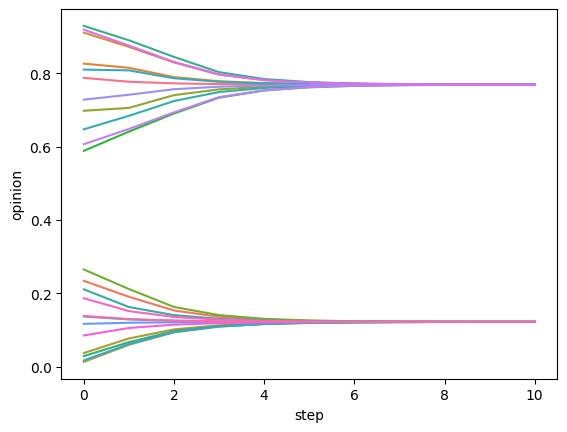

In [156]:
rainer.plot_opinion_evolution()

In [157]:
rainer.df.step.unique().tolist()[:-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [158]:
rainer.df[rainer.df.step.eq(10)].distances.apply(pd.Series).unstack().dropna().to_list()

[0.6468205565210324,
 0.6468845862648406,
 0.6470338132569385,
 0.00023848683687416328,
 0.00020696158188256153,
 0.6467006665636501,
 3.854773235820175e-05,
 0.6465138834524459,
 0.00022556240388595106,
 0.6470899117309096,
 5.083033565347894e-05,
 0.646640900435519,
 0.6468726704205103,
 0.0002351604203414126,
 0.00011219431469777774,
 0.00012886438467415995,
 0.6467609686954968,
 0.64652547861032,
 0.6470393312543781,
 0.00015495991462785574,
 7.1008066991049e-05,
 0.00011100439424858999,
 6.402974380814719e-05,
 0.6468845862648406,
 0.00014922699209796164,
 0.6471230731017148,
 0.6470915478467232,
 0.0001839197011904714,
 0.6468460385324823,
 0.0003707028123947076,
 0.6471101486687265,
 0.00020532546606899515,
 0.646935416600494,
 0.00024368582932154936,
 1.191584433024584e-05,
 0.647119746685182,
 0.6469967805795384,
 0.6470134506495148,
 0.00012361756934375911,
 0.00035910765452062954,
 0.00015474498953749194,
 0.6470395461794685,
 0.6469555943318316,
 0.6469955906590892,
 0.0002

<AxesSubplot:ylabel='Count'>

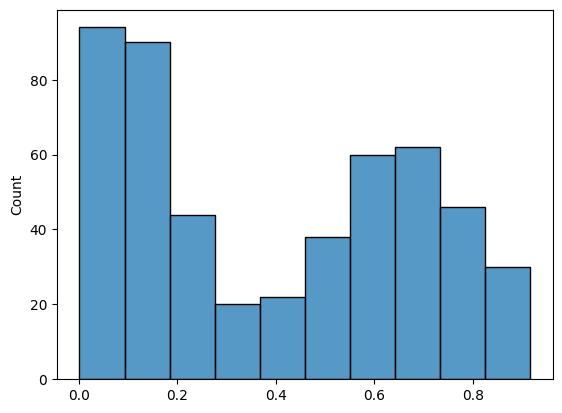

In [159]:
rainer.diff_hist(1)


In [160]:
rainer.get_diff_evolution()

,metric,value,step
0,Q0.10,0.049723,0
1,Q0.25,0.117347,0
2,Q0.50,0.382230,0
3,Q0.75,0.660580,0
4,Q0.90,0.789108,0
...,...,...,...
85,Q0.90,0.647141,9
86,mean,0.337611,9
87,median,0.646576,9
88,min,0.000001,9


<AxesSubplot:xlabel='step', ylabel='value'>

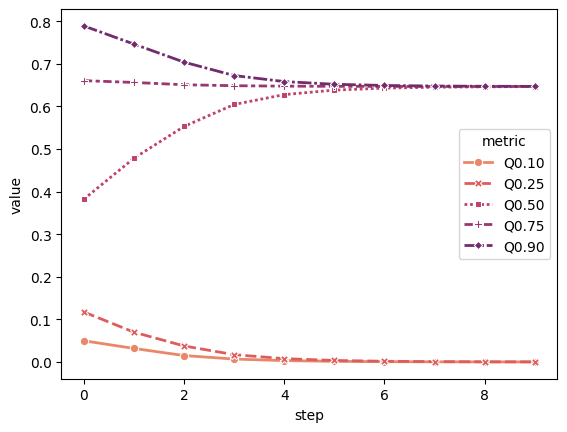

In [161]:
rainer.plot_diff_evolution()

## Natural-language BC Model

In [158]:
class NaturalLanguageBCAgent(AbstractBCAgent):

    async def distance(self, other):
        """calculates distance between agent's and other opinion"""
        lmql_result = await agreement(
            self.opinion,
            other,
            model=self._parameters["model"]
        )
        probs = lmql_result.variables.get("P(LABEL)")
        return sum([i*v for i, (_, v) in enumerate(probs)])/4.0

    async def revise(self, opinions):
        """revision through weighted opinion averaging"""
        revision = await revise(
            opinion=self.opinion,
            peer_opinions=opinions,
            self_confidence=self._parameters.get("self_confidence", "average"),
            topic=self._parameters.get("topic", "veganism"),
            model=self._parameters["model"]
        )
        return revision

In [143]:
parameters = {
    "model": model,
    "self_confidence": "very high",
    "topic": "veganism",
    "epsilon": .5
}
stances = [
    "affirming",
    "denying",
    "loosely related to",
    "vaguely putting in doubt",
    "based on (positive or negative) personal experience regarding"
]


In [144]:
from tqdm import tqdm

initial_opinions = []

for stance in tqdm(stances):

    claims = await init(
        topic=parameters["topic"],
        stance=stance,
        n=2,
        model=model
    )
    initial_opinions.extend(claims)

initial_opinions

100%|█████████████████████████████████████████████| 5/5 [00:56<00:00, 11.32s/it]


['A plant-based diet is scientifically proven to be the healthiest option for humans and has been shown to reduce the risk of chronic diseases such as heart disease and cancer.',
 'Raising animals for food requires a higher ecological footprint and contributes significantly to greenhouse gas emissions and deforestation.',
 'Eating meat is necessary for a healthy and complete diet.',
 'The benefits of consuming animal products outweigh the negative consequences.',
 'Eating a plant-based diet has been shown to reduce the risk of certain cancers.',
 'Factory farming contributes significantly to water and air pollution, and negatively impacts wildlife populations.',
 'A vegan diet can lead to nutrient deficiencies that are not easily compensated for with supplements, potentially causing long-term health problems.',
 "While veganism may align with some individuals' beliefs, there is no scientific consensus on the superiority of a vegan diet for optimal health.",
 'On a vegan diet, I feel mo

In [159]:
community = EpistemicCommunity([
    NaturalLanguageBCAgent(io,**parameters)
    for io in initial_opinions
])

In [160]:
await community.interact(5)

STEP:   0%|                                               | 0/5 [00:00<?, ?it/s]

{'28daddba-6833-4103-b539-20f6a2491c9a': 0.38389033216305274, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.5877821625054145, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.5328110885155823, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.37103941641439175, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.41860245930635925, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.5850586350202232, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.472188260011214, 'b6a6bc6c-8e01-4a63-a691-8569da0e52c5': 0.44125100443703935, 'd49a6c12-4db9-4379-b357-30963df09b58': 0.4251994670550855}
{'e6fcd7b5-ace9-4fa1-bada-406386e7d14e': 0.41113802345278094, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.5019325130697949, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.6051151992031856, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.43646484263849084, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.4207855481295145, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.4870313524744223, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.4715498602309317, 'b6a6bc6c-8e01-4a63-a691-8569da0e

STEP:  20%|███████▌                              | 1/5 [02:25<09:42, 145.74s/it]

{'28daddba-6833-4103-b539-20f6a2491c9a': 0.38915752845032725, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.4138826361338656, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.35642547320113066, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.34084395026015696, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.43684233835979414, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.4292095613924074, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.4228944923109916, 'b6a6bc6c-8e01-4a63-a691-8569da0e52c5': 0.47495638602221646, 'd49a6c12-4db9-4379-b357-30963df09b58': 0.4409736698212873}
{'e6fcd7b5-ace9-4fa1-bada-406386e7d14e': 0.4112849534820771, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.42586552924667737, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.28481822649486155, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.35880213899424934, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.2851546192678922, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.39293272346413755, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.4872507403484337, 'b6a6bc6c-8e01-4a63-a691-8569

STEP:  40%|███████████████▏                      | 2/5 [05:44<08:50, 176.91s/it]

{'28daddba-6833-4103-b539-20f6a2491c9a': 0.38327482579439315, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.3475524789300431, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.40547136467841566, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.3439301046369382, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.42837286191443, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.3786793629212145, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.4123096011645101, 'b6a6bc6c-8e01-4a63-a691-8569da0e52c5': 0.37708923200465294, 'd49a6c12-4db9-4379-b357-30963df09b58': 0.4289146118231217}
{'e6fcd7b5-ace9-4fa1-bada-406386e7d14e': 0.25595534238096623, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.34312330222428766, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.3408364437012535, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.34452442589795657, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.4341649720105801, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.30495223997686993, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.4080367647412704, 'b6a6bc6c-8e01-4a63-a691-8569da0e

STEP:  60%|██████████████████████▊               | 3/5 [08:22<05:37, 168.51s/it]

{'28daddba-6833-4103-b539-20f6a2491c9a': 0.2681960458707211, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.3413828790149047, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.4108551100297467, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.3022377749204521, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.31185528214847114, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.336447470294341, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.3824642337962506, 'b6a6bc6c-8e01-4a63-a691-8569da0e52c5': 0.31185528214847114, 'd49a6c12-4db9-4379-b357-30963df09b58': 0.3653126319661044}
{'e6fcd7b5-ace9-4fa1-bada-406386e7d14e': 0.3561467381333996, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.4248669860267658, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.4120862008501918, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.32925912374292543, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.23355778401062086, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.3920559950050017, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.4208944502721897, 'b6a6bc6c-8e01-4a63-a691-8569da0e52

STEP:  80%|██████████████████████████████▍       | 4/5 [10:57<02:42, 162.87s/it]

{'28daddba-6833-4103-b539-20f6a2491c9a': 0.39412928645184, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.41724842314568433, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.3662345679014053, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.37971499824510696, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.2833704262814056, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.2764342369618435, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.30445373458957115, 'b6a6bc6c-8e01-4a63-a691-8569da0e52c5': 0.3756065492399598, 'd49a6c12-4db9-4379-b357-30963df09b58': 0.4173848666290084}
{'e6fcd7b5-ace9-4fa1-bada-406386e7d14e': 0.3656747030986119, 'c7c42adc-6c14-4c90-b38f-f6b3934143ff': 0.3707503301207755, 'b606334e-bfa9-4fb0-af81-f7fdf43d9dad': 0.3334575440084503, '04be7343-39b5-4f14-84fc-5fd8480d7a0d': 0.3803253495466121, '58a2ffd4-c4d5-46f9-8298-d00b7644fcee': 0.44032856382750774, '6bfea1d0-d98c-4460-87fe-7d8381c38f90': 0.3389574177439749, 'c32b29da-1b94-4d93-8b30-111590066eb6': 0.31937013879995607, 'b6a6bc6c-8e01-4a63-a691-8569da0e52

STEP: 100%|██████████████████████████████████████| 5/5 [13:10<00:00, 158.10s/it]


In [ ]:
rainer = Rainer(community.logs)

<AxesSubplot:ylabel='Count'>

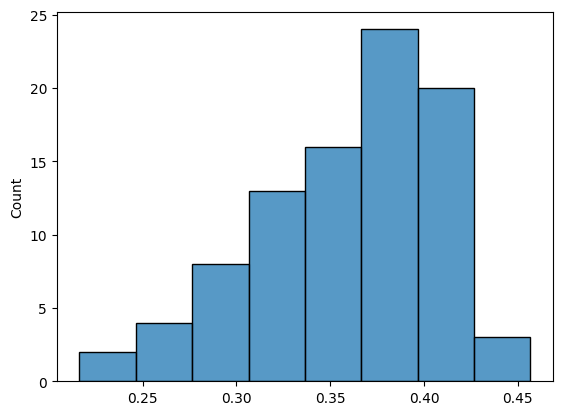

In [ ]:
rainer.diff_hist(5)

In [ ]:
rainer.get_diff_evolution()